In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
LANGSMITH_TRACING = os.getenv("LANGSMITH_TRACING")
LANGSMITH_ENDPOINT = os.getenv("LANGSMITH_ENDPOINT")
LANGSMITH_API_KEY = os.getenv("LANGSMITH_API_KEY")
LANGSMITH_PROJECT = os.getenv("LANGSMITH_PROJECT")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
# TRAVILY_PROJECT = os.getenv("TRAVILY_PROJECT")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = os.getenv("LANGSMITH_TRACING")
os.environ["LANGSMITH_ENDPOINT"] = os.getenv("LANGSMITH_ENDPOINT")
os.environ["LANGSMITH_PROJECT"] = os.getenv("LANGSMITH_PROJECT")

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")



In [3]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro-latest")

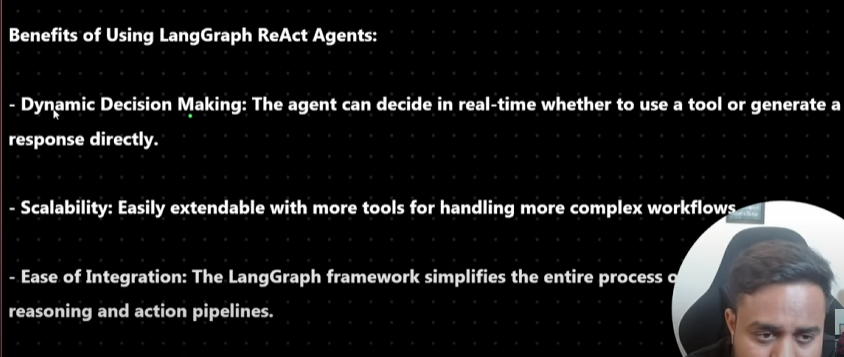

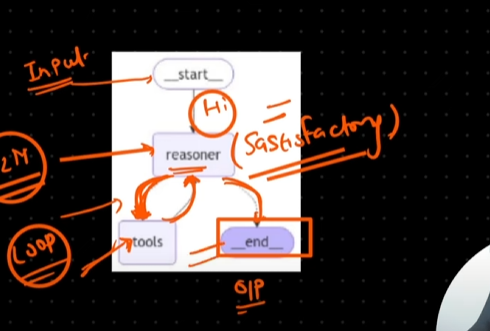

In [4]:


from langgraph.graph import MessagesState,StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode

In [5]:
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b

In [6]:
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

In [7]:

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [9]:
search = DuckDuckGoSearchRun()

In [11]:
search.invoke("who is the prime minister of india")

c:\Users\gagan\anaconda3\envs\chain\lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


"Jul 25, 2025 · Currently, Narendra Modi is the Prime Minister of India, having been in office since 2014. He is the 14th Prime Minister of India who had three consecutive terms on the post. The prime minister is appointed by the president of India; however, the prime minister has to enjoy the confidence of the majority of Lok Sabha members, who are directly elected every five … Shri Narendra Modi was sworn-in as India’s Prime Minister for the third time on 9th June 2024, following another decisive victory in the 2024 Parliamentary elections. This victory marked the … Jawahar Lal Nehru, the first prime minister of India was appointed on 15th August 1947 and Narendra Damodardas Modi is the current prime minister of India. He took the Prime Minister's … Aug 2, 2025 · Narendra Modi is the current Prime Minister of India, serving since 2014. He took the oath for his third term on June 9, 2024, making him the second longest-serving Prime …"

In [12]:
tools=[add, multiply, divide, search]

In [14]:
llm_with_tools=llm.bind_tools(tools)

In [15]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")
     

In [16]:
def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [17]:
# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)

builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")

builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "reasoner")
react_graph = builder.compile()
     

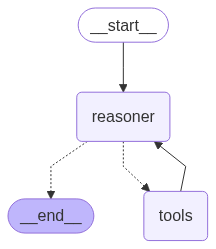

In [18]:
# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [20]:
messages = [HumanMessage(content="What is 2 times of narendramodi's age?")]
     

In [21]:

messages = react_graph.invoke({"messages": messages})

c:\Users\gagan\anaconda3\envs\chain\lib\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


In [22]:
for m in messages['messages']:
    m.pretty_print()
     

================================ Human Message =================================

What is 2 times of narendramodi's age?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (2bd53d36-214f-4341-926e-ebf560bbfe67)
 Call ID: 2bd53d36-214f-4341-926e-ebf560bbfe67
  Args:
    query: narendra modi age
================================= Tool Message =================================
Name: duckduckgo_search

Aug 5, 2025 · With a mesmerizing blend of charisma and controversy, Narendra Modi, the 14th Prime Minister of India, has left an indelible mark on the country's political Sep 17, 2024 · Narendra Modi, born on September 17, 1950, in Vadnagar, Gujarat, is the current Prime Minister of India. Known for his dynamic leadership, Modi has emerged as a prominent … Aug 13, 2024 · Narendra Modi (born 17 September 1950) is an Indian Politician, 14th Prime Minister of India, and BJP leader from Vadnagar, Gujarat, India. His political party is 

In [27]:
import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets the latest available stock price from Yahoo Finance."""
    stock = yf.Ticker(ticker)

    # Try fast_info first (faster, more reliable)
    try:
        return stock.fast_info.last_price
    except Exception:
        pass

    # Fallback to 'previousClose' if it exists
    info = stock.info
    if 'previousClose' in info:
        return info['previousClose']

    # Last fallback: fetch recent historical data
    hist = stock.history(period="2d")
    if not hist.empty:
        return hist['Close'].iloc[-1]

    raise ValueError(f"Price data not available for ticker: {ticker}")


In [30]:

get_stock_price("AAPL")
     

227.17999267578125

In [32]:

tools = [add, multiply, divide, search, get_stock_price]

In [33]:
llm_with_tools = llm.bind_tools(tools)

In [34]:
def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}

In [35]:


class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]

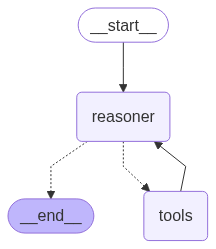

In [36]:
# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [37]:

response = react_graph.invoke({"query": "What is the stock price of Apple add 1000?", "messages": []})

In [38]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (e5ced0d1-1e42-4882-83b3-43493ba6d196)
 Call ID: e5ced0d1-1e42-4882-83b3-43493ba6d196
  Args:
    ticker: AAPL
  add (8db71310-4c4f-4bff-967d-79da1b4b5ae1)
 Call ID: 8db71310-4c4f-4bff-967d-79da1b4b5ae1
  Args:
    b: 0.0
    a: 1000.0
================================= Tool Message =================================
Name: get_stock_price

227.17999267578125
================================= Tool Message =================================
Name: add

1000
================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message ==================================

Apple's current stock price is $227.18. Adding 1000 to that results in $1227.18.
